In [1]:
import bayes3d as b
import os
import sys
import jax.numpy as jnp
import jax
import bayes3d.genjax
import genjax
import matplotlib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import flax.linen as nn
from flax.training import train_state
import flax
import optax
from tensorflow_probability.substrates import jax as tfp

In [3]:
import pickle
from typing import Any, Union

## CNN Inference

## 

In [4]:
NoneType = type(None)

In [5]:
class BaseCNN(nn.Module):
    range_min: Union[float, jnp.ndarray]
    range_max: Union[float, jnp.ndarray, NoneType]

    @nn.compact
    def __call__(self, imgs, train: bool): # XXX todo: make sure the sizes all line up
        x = nn.Conv(64, (10, 10), strides=(3, 3), padding='VALID')(imgs)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.activation.relu(x)
        x = nn.max_pool(x, (3, 3), strides=(2, 2))
        
        x = nn.Conv(256, (5, 5), strides=(2, 2), padding='VALID')(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.activation.relu(x)
        x = nn.max_pool(x, (2, 2), strides=(2, 2))
        
        x = nn.Dense(1024)(x.reshape(imgs.shape[0], -1))
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.activation.relu(x)
        
        #x = nn.Dense(1024)(x)
        #x = nn.BatchNorm(use_running_average=not train)(x)
        #x = nn.activation.leaky_relu(x)

        # x = nn.Dropout(rate=0.5, deterministic=not train)(x)
        
        # x = nn.Dense(1024)(x)
        # x = nn.BatchNorm(use_running_average=not train)(x)
        # x = nn.activation.leaky_relu(x)
        
        # x = nn.Dense(1024)(x)
        # x = nn.BatchNorm(use_running_average=not train)(x)
        # x = nn.activation.leaky_relu(x)
        
        # x = nn.Dropout(rate=0.5, deterministic=not train)(x)
        
        x = nn.Dense(576)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.activation.relu(x)
        
        # x = nn.Dropout(rate=0.5, deterministic=not train)(x)

        x = nn.Dense(192)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.activation.relu(x)

        x = nn.Dense(24)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.activation.relu(x)

        x = nn.Dense(1)(x)
        if self.range_max is not None:
            shift = (self.range_max + self.range_min) / 2
            scale = (self.range_max - self.range_min) / 2
            x = shift + scale * nn.soft_sign(x)
        else:
            x = nn.activation.relu(x)
        return x

In [6]:
class SceneModel(nn.Module):
    mean_model: nn.Module
    std_model: nn.Module

    @nn.compact
    def __call__(self, imgs, train: bool):
        means = self.mean_model(imgs, train)
        stds = self.std_model(imgs, train)
        return means, stds

In [7]:
cnn = SceneModel(mean_model=BaseCNN(0, 2*jnp.pi), std_model=BaseCNN(0, None))
params_key = jax.random.PRNGKey(0)
rngs = {'params': params_key} 
cnn.tabulate(rngs, jnp.zeros((1, 100, 100, 1)), False, console_kwargs={'force_jupyter': True})

                                                SceneModel Summary                                                 
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ path              ┃ module     ┃ inputs            ┃ outputs           ┃ params            ┃ batch_stats        ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│                   │ SceneModel │ -                 │ - float32[1,1]    │                   │                    │
│                   │            │ float32[1,100,10… │ - float32[1,1]    │                   │                    │
│                   │            │ - False           │                   │                   │                    │
├───────────────────┼────────────┼───────────────────┼───────────────────┼───────────────────┼────────────────────┤
│ mean_model        │ BaseCNN    │ -                 │ float32[1,1]      │                   │                    │
│                   │            │ float32[1,100,10… │                   │                   │                    │
│                   │            │ - False           │                   │                   │                    │
├───────────────────┼────────────┼───────────────────┼───────────────────┼───────────────────┼────────────────────┤
│ mean_model/Conv_0 │ Conv       │ float32[1,100,10… │ float32[1,31,31,… │ bias: float32[64] │                    │
│                   │            │                   │                   │ kernel:           │                    │
│                   │            │                   │                   │ float32[10,10,1,… │                    │
│                   │            │                   │                   │                   │                    │
│                   │            │                   │                   │ 6,464 (25.9 KB)   │                    │
├───────────────────┼────────────┼───────────────────┼───────────────────┼───────────────────┼────────────────────┤
│ mean_model/Batch… │ BatchNorm  │ float32[1,31,31,… │ float32[1,31,31,… │ bias: float32[64] │ mean: float32[64]  │
│                   │            │                   │                   │ scale:            │ var: float32[64]   │
│                   │            │                   │                   │ float32[64]       │                    │
│                   │            │                   │                   │                   │ 128 (512 B)        │
│                   │            │                   │                   │ 128 (512 B)       │                    │
├───────────────────┼────────────┼───────────────────┼───────────────────┼───────────────────┼────────────────────┤
│ mean_model/Conv_1 │ Conv       │ float32[1,15,15,… │ float32[1,6,6,25… │ bias:             │                    │
│                   │            │                   │                   │ float32[256]      │                    │
│                   │            │                   │                   │ kernel:           │                    │
│                   │            │                   │                   │ float32[5,5,64,2… │                    │
│                   │            │                   │                   │                   │                    │
│                   │            │                   │                   │ 409,856 (1.6 MB)  │                    │
├───────────────────┼────────────┼───────────────────┼───────────────────┼───────────────────┼────────────────────┤
│ mean_model/Batch… │ BatchNorm  │ float32[1,6,6,25… │ float32[1,6,6,25… │ bias:             │ mean: float32[256] │
│                   │            │                   │                   │ float32[256]      │ var: float32[256]  │
│                   │            │                   │                   │ scale:            │                    │
│                   │            │                   │  

'\n\n'

In [8]:
class TrainState(train_state.TrainState):
    batch_stats: Any

In [9]:
def create_train_state(module, key, learning_rate, momentum, params=None):
    """Creates an initial `TrainState`."""
    #params_key, dropout_key = jax.random.split(key, 2)
    # initialize parameters by passing a template image
    variables = module.init(key,#, 'dropout': dropout_key},
                            jnp.ones([BATCH_SIZE, 100, 100, 1]), train=False)
    if params is None:
        params = variables['params']
    batch_stats = variables['batch_stats']
    tx = optax.sgd(learning_rate, momentum)
    return TrainState.create(apply_fn=module.apply, params=params, tx=tx,
                             batch_stats=batch_stats)#, dropout_key=dropout_key)

In [10]:
normal_logpdf = jax.scipy.stats.norm.logpdf
truncnormal_logpdf = jax.scipy.stats.truncnorm.logpdf
beta_logpdf = jax.scipy.stats.beta.logpdf
vonmises = tfp.distributions.VonMises

In [11]:
@jax.jit
def train_step(state, img_batch, label_batch): 
    """Train for a single step."""
    def loss_fn(params):
        (means, stds), updates = state.apply_fn({'params': params, 'batch_stats': state.batch_stats},
                                                img_batch,
                                                train=True,
                                                mutable=['batch_stats'])
        #loss = -normal_logpdf(label_batch, loc=means, scale=stds).sum()
        loss = -vonmises(loc=means, concentration=stds).log_prob(label_batch).sum()
        #loss = jnp.sum((means - label_batch)**2)
        return loss, updates
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, updates), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    state = state.replace(batch_stats=updates['batch_stats'])
    return state, loss

In [109]:
train_data_file = jnp.load('train_data_noxy_1e5.npz')
test_data_file = jnp.load('test_data_noxy.npz')
test_data_file_noisy = jnp.load('test_data_noxy_noisy.npz')

In [110]:
train_imgs = train_data_file['arr_0'][:50000]
train_labels = train_data_file['arr_1'][:50000]

In [111]:
train_imgs.shape, train_labels.shape

((50000, 100, 100, 1), (50000, 1))

In [112]:
test_imgs = test_data_file['arr_0']
test_labels = test_data_file['arr_1']

In [113]:
test_imgs.shape, test_labels.shape

((2000, 100, 100, 1), (2000, 1))

In [114]:
test_imgs_noisy = test_data_file_noisy['arr_0']
test_labels_noisy = test_data_file_noisy['arr_1']

In [115]:
test_imgs.shape, test_labels.shape

((2000, 100, 100, 1), (2000, 1))

In [138]:
N_TRAIN = train_imgs.shape[0]
N_TEST = test_imgs.shape[0]
N_EPOCHS = 10
BATCH_SIZE = 20 #20
LEARNING_RATE = 1e-5 #1e-8
MOMENTUM = 0.9
assert N_TRAIN % BATCH_SIZE == 0
assert N_TEST % BATCH_SIZE == 0

In [139]:
state = create_train_state(cnn, jax.random.PRNGKey(0), LEARNING_RATE, MOMENTUM)

In [140]:
shuffling_key = jax.random.PRNGKey(1)

In [141]:
# with open('param_file_noxy_1e5_50.pkl', 'rb') as params_file:
#      loaded_params = pickle.load(params_file)
# state = create_train_state(cnn, jax.random.PRNGKey(0), LEARNING_RATE, MOMENTUM, params=loaded_params)

In [142]:
 training_losses = []

In [143]:
for epoch in range(N_EPOCHS):
    training_losses.append([])
    perm = jax.random.permutation(shuffling_key, N_TRAIN)
    train_imgs = train_imgs[perm]
    train_labels = train_labels[perm]
    shuffling_key = jax.random.split(shuffling_key, 2)[1]

    for step in tqdm(range(N_TRAIN // BATCH_SIZE)):
        img_batch = train_imgs[step*BATCH_SIZE:(step+1)*BATCH_SIZE]
        label_batch = train_labels[step*BATCH_SIZE:(step+1)*BATCH_SIZE]
        
        state, loss = train_step(state, img_batch, label_batch)
        training_losses[-1].append(loss)
        #print(loss)
        #os.system('nvidia-smi')

    epoch_loss = jnp.array(training_losses[-1]).mean()
    #epoch_train_loss = calc_avg_loss_batched(state, train_imgs, train_labels)
    #epoch_test_loss = calc_avg_loss_batched(state, test_imgs, test_labels)
    
    epoch_train_loss = 'not calculated'
    epoch_test_loss = 'not calculated'
    print(f'epoch: {epoch}, average loss: {epoch_loss}, '
          f'train loss: {epoch_train_loss}, '
          f'test loss: {epoch_test_loss}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:09<00:00, 255.06it/s]


epoch: 0, average loss: 13.722162246704102, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 409.08it/s]


epoch: 1, average loss: 2.9726874828338623, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 408.62it/s]


epoch: 2, average loss: -1.716426968574524, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 414.48it/s]


epoch: 3, average loss: -4.899789810180664, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 413.18it/s]


epoch: 4, average loss: -7.172534942626953, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 414.42it/s]


epoch: 5, average loss: -8.979629516601562, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 413.62it/s]


epoch: 6, average loss: -10.331128120422363, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 418.77it/s]


epoch: 7, average loss: -12.052774429321289, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 415.33it/s]


epoch: 8, average loss: -12.625371932983398, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 417.07it/s]


epoch: 9, average loss: -14.068185806274414, train loss: not calculated, test loss: not calculated


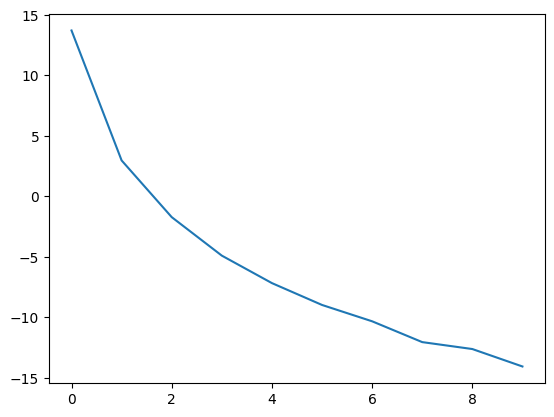

In [144]:
plt.plot([jnp.array(l).mean() for l in training_losses])

In [145]:
# with open('param_file_noxy_1e5_50.pkl', 'wb') as params_file:
#      pickle.dump(state.params, params_file)

In [146]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.0001, far=2.0
)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
b.RENDERER.add_mesh_from_file(model_dir + '/obj_000014.ply', scaling_factor=1e-3)
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)

table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.8, .15]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [147]:
def get_poses_non_jit(contact_params, id_table, id):
    sg = b.scene_graph.SceneGraph(
        root_poses=jnp.array([table_pose, jnp.eye(4)]),
        box_dimensions=jnp.array([b.RENDERER.model_box_dims[id_table], b.RENDERER.model_box_dims[id]]),
        parents=jnp.array([-1, 0]),
        contact_params=jnp.array([jnp.zeros(3), contact_params]),
        face_parent=jnp.array([-1,2]),
        face_child=jnp.array([-1,3]),
    )
    poses = sg.get_poses()
    return poses
get_poses = jax.jit(get_poses_non_jit)

def render_image_non_jit(dx, dy, theta):
    id_table = 1
    id = 0
    poses = get_poses_non_jit(jnp.array([dx, dy, theta]), id_table, id)
    img = b.RENDERER.render(
        poses , jnp.array([id_table, id])
    )[...,:3]
    return img
    
render_image = jax.jit(render_image_non_jit)

In [148]:
i = 0
means, _ = state.apply_fn({'params': state.params, 'batch_stats': state.batch_stats},
                        train_imgs[i, :, :, 0].reshape((1, 100, 100, 1)), train=False, mutable=False)
means

Array([[2.2245767]], dtype=float32)

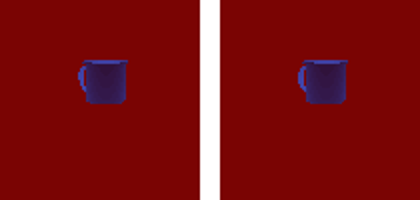

In [149]:
b.viz.scale_image(b.viz.hstack_images([b.get_depth_image(render_image(0, 0, means.flatten()[0])[:, :, 2]),
                                       b.get_depth_image(train_imgs[i, :, :, 0])]), 2)

In [150]:
def prediction_img(i, arr=test_imgs):
    means, stds = state.apply_fn({'params': state.params, 'batch_stats': state.batch_stats},
                               arr[i, :, :, 0].reshape((1, 100, 100, 1)), train=False, mutable=False)
    return b.get_depth_image(render_image(0, 0, means.flatten()[0])[:, :, 2]), means, stds

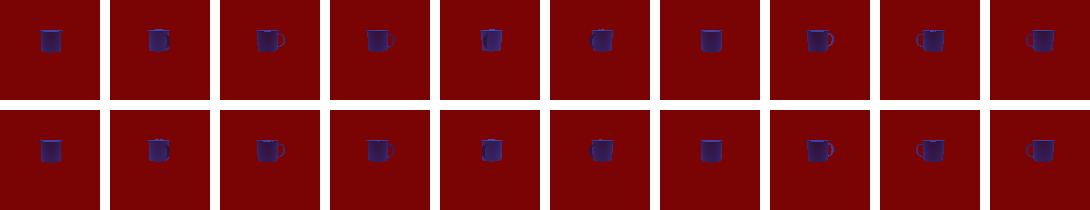

In [151]:
idxs = jax.random.randint(jax.random.PRNGKey(3141), (10,), 0, N_TEST)
imgs, means,stds = zip(*[prediction_img(i) for i in idxs])
gt_imgs = [b.get_depth_image(test_imgs[i, :, :, 0]) for i in idxs]
b.viz.vstack_images([b.viz.hstack_images(imgs),
                     b.viz.hstack_images(gt_imgs)])

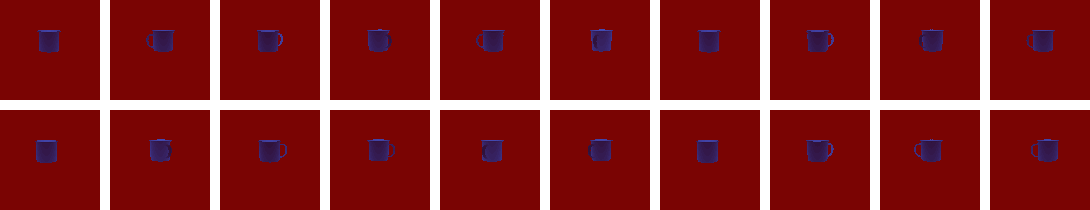

In [152]:
idxs = jax.random.randint(jax.random.PRNGKey(3141), (10,), 0, N_TEST)
imgs, means,stds = zip(*[prediction_img(i, test_imgs_noisy) for i in idxs])
gt_imgs = [b.get_depth_image(test_imgs_noisy[i, :, :, 0]) for i in idxs]
b.viz.vstack_images([b.viz.hstack_images(imgs),
                     b.viz.hstack_images(gt_imgs)])

In [153]:
means, stds = state.apply_fn({'params': state.params, 'batch_stats': state.batch_stats},
                             test_imgs, train=False, mutable=False)
-vonmises(loc=means, concentration=stds).log_prob(test_labels).sum()

Array(-1644.2332, dtype=float32)

In [154]:
means, stds = state.apply_fn({'params': state.params, 'batch_stats': state.batch_stats},
                             test_imgs_noisy, train=False, mutable=False)
-vonmises(loc=means, concentration=stds).log_prob(test_labels_noisy).sum()

Array(21349.191, dtype=float32)